In [1]:
# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

""

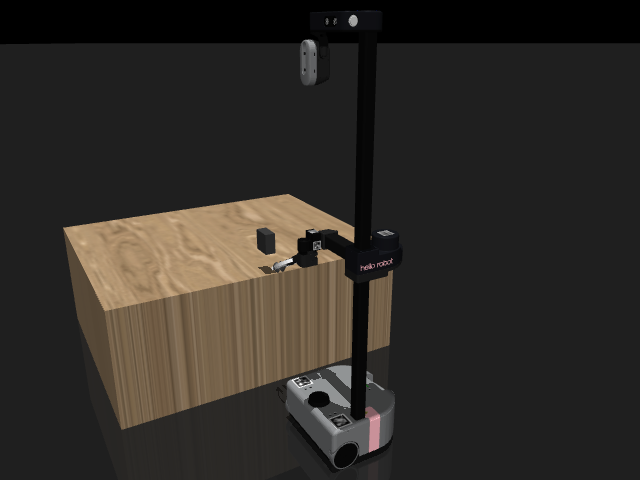

In [2]:
from pathlib import Path
import enum
from tqdm import tqdm

class Resolution(enum.Enum):
  SD = (480, 640)
  HD = (720, 1280)
  UHD = (2160, 3840)

res = Resolution.SD
h, w = res.value

model_dir = Path("mujoco_menagerie/hello_robot_stretch") # You could also use google_robot
model_xml = model_dir / "scene.xml"

# Load model.
model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)

# Make sure offscreen rendering can support the desired resolution.
model.vis.global_.offheight = h
model.vis.global_.offwidth = w

renderer = mujoco.Renderer(model, height=h, width=w)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [3]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [4]:
vis = mujoco.MjvOption()
vis.geomgroup[2] = True
vis.geomgroup[3] = False
coll = mujoco.MjvOption()
coll.geomgroup[2] = False
coll.geomgroup[3] = True
coll.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 4

duration = 10
fps = 30
nsteps = int(np.ceil(duration / model.opt.timestep))

# Set the desired control point.
if model.nkey > 0:
  mujoco.mj_resetDataKeyframe(model, data, 0)
  ctrl0 = data.ctrl.copy()
else:
  mujoco.mj_resetData(model, data)
  ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)


In [8]:
from math import *

class Robot:
    def __init__(self, model, data, vis, coll, camera):
        self.model = model
        self.data = data
        self.vis = vis
        self.coll = coll
        self.camera = camera
        self.x = 0
        self.y = 0
        self.tangent_angle = 0.0
        self.velocity = 0.0
        self.breadth = 0.0
        self.dt = 0.1
        
    def set_wheel_speeds(self, left_speed, right_speed):
        self.data.joint('joint_right_wheel').qvel = np.array([right_speed])
        self.data.joint('joint_left_wheel').qvel = np.array([left_speed])
    
    def distance_to_point(self, x_goal, y_goal, x, y):
        return sqrt((x_goal - x) ** 2 + (y_goal - y) ** 2)
    
    def arc_radius(x1, y1, x2, y2, tangent_angle):
        centre_x = (x1 + x2) / 2
        centre_y = (y1 + y2) / 2
        chord_length = sqrt((x2 - x1)**2 + (y2 - y1)**2)
        chord_angle = atan2(y2 - y1, x2 - x1)
        radius = chord_length / (2 * sin(pi - tangent_angle - abs(chord_angle)))
        next_angle = chord_angle * 2
        return radius, next_angle
    
    def update_position(self, left_speed, right_speed, dt):
        wheel_base = self.breadth
        v = (left_speed + right_speed) / 2.0
        omega = (right_speed - left_speed) / wheel_base
        self.x += v * cos(self.tangent_angle) * dt
        self.y += v * sin(self.tangent_angle) * dt
        self.tangent_angle += omega * dt
    
    def control_robot_to_point(self, x_goal, y_goal):
        duration = 10
        fps = 30
        nsteps = int(np.ceil(duration / model.opt.timestep))
        x = self.x
        y = self.y

        # Set the desired control point.
        if model.nkey > 0:
            mujoco.mj_resetDataKeyframe(model, data, 0)
            ctrl0 = data.ctrl.copy()
        else:
            mujoco.mj_resetData(model, data)
            ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)

        frames = []
        
        for i in tqdm(range(nsteps)):
        # while self.distance_to_point(self, x_goal, y_goal, self.x, self.y) > self.threshold:
            if self.distance_to_point(self, x_goal, y_goal, self.x, self.y) > self.threshold:
                distance = self.distance_to_point(self, x_goal, y_goal, self.x, self.y)                
                radius, next_angle = self.arc_radius(self.x, self.y, x_goal, y_goal, self.tangent_angle)
                angle_to_goal = atan2(y_goal - self.y, x_goal - self.x)
                angle_diff = angle_to_goal * 2
                # angle_diff = angle_to_goal - self.theta
                # omega = self.velocity / radius
                # omega = self.velocity / radius
                
                if angle_diff > pi:
                    angle_diff -= 2 * pi
                elif angle_diff < -pi:
                    angle_diff += 2 * pi
                
                if radius == 0:
                    v_left = self.velocity
                    v_right = self.velocity
                else:
                    omega = self.velocity / radius
                    v_left = self.velocity * (radius + self.breadth/2) / radius
                    v_right = self.velocity * (radius - self.breadth/2) / radius
                # print(distance, radius, v_left, v_right)
                # v_left = v - omega * angle_diff
                # v_right = v + omega * angle_diff
                
                # self.set_wheel_speeds(self, v_left, v_right)
                self.set_wheel_speeds(self, v_left, v_right)
                self.update_position(self, v_left, v_right, self.dt)

                '''  ### #### ###  '''
                # for i in tqdm(range(nsteps)):
                
                # print(v_left, v_right)
                # data.joint('joint_right_wheel').qvel = np.array([rv])
                # data.joint('joint_left_wheel').qvel = np.array([rl])
            else:
                self.set_wheel_speeds(self, 0, 0)

            mujoco.mj_step(model, data)
            if len(frames) < data.time * fps:
                renderer.update_scene(data, self.camera, scene_option=self.vis)
                vispix = renderer.render().copy().astype(np.float32)
                frame = vispix.astype(np.uint8)
                frames.append(frame)
                
        media.show_video(frames, fps=fps, loop=False)

        self.set_wheel_speeds(self, 0, 0)
        print("Reached the goal and stopped.")

robot = Robot
robot.__init__(robot, model, data, vis, coll, camera)
robot.velocity = 1
robot.breadth = 0.2
x_goal, y_goal = 0, 2
robot.x, robot.y = 0, 0 
robot.threshold = 1
robot.tangent_angle = 0
robot.control_robot_to_point(robot, x_goal, y_goal)

  3%|▎         | 150/5000 [00:00<00:03, 1472.71it/s]

2.0 1.0 1.1 0.9
2.0024984394500787 1.0025041743167382 1.0997502080908097 0.9002497919091903
2.0198597599745116 1.0150844578573894 1.0985139701686273 0.9014860298313728
2.0515131390329637 1.03783762570483 1.0963541863613653 0.9036458136386348
2.096396654966242 1.0708371588088572 1.0933848803969735 0.9066151196030265
2.15308874000638 1.114163368325336 1.089753444461477 0.9102465555385231
2.2199648398738527 1.1679367451723932 1.085621075296539 0.914378924703461
2.2953460958041823 1.232346549538946 1.0811460055918627 0.9188539944081372
2.3776177631906 1.3076708380856465 1.0764718437450163 0.9235281562549836
2.465308798285827 1.394288094850733 1.0717211890206275 0.9282788109793725
2.5571347446052037 1.4926828470791424 1.0669934676315727 0.9330065323684275
2.652011709479344 1.6034481275303207 1.0623655971671644 0.9376344028328356
2.749050631273544 1.7272871348626615 1.057894253932454 0.9421057460675458
2.8475399678413367 1.8650156534914757 1.053618852910318 0.946381147089682
2.94692292364976

 10%|█         | 500/5000 [00:00<00:02, 1650.66it/s]

33.917378674841736 -900.2889115293137 0.9998889245455327 1.0001110754544673
34.01737796133034 -908.837913747191 0.9998899693790417 1.0001100306209583
34.11737720961133 -917.4605797743578 0.9998910034913712 1.000108996508629
34.21737641920619 -926.1575334580516 0.9998920270079469 1.0001079729920532
34.31737558966839 -934.9294047143563 0.9998930400525475 1.0001069599474526
34.41737472058234 -943.7768296001669 0.9998940427473278 1.000105957252672
34.517373811562386 -952.7004503853158 0.999895035212842 1.000104964787158
34.61737286225185 -961.7009156260145 0.9998960175680659 1.000103982431934
34.717371872322076 -970.7788802397545 0.9998969899304203 1.0001030100695798
34.81737084147149 -979.9350055803997 0.9998979524157923 1.0001020475842077
34.91736976942475 -989.1699595152096 0.9998989051385577 1.0001010948614422
35.017368655931826 -998.4844165025517 0.9998998482116023 1.0001001517883978
35.1173675007672 -1007.8790576708457 0.9999007817463426 1.0000992182536574
35.21736630372902 -1017.354

 17%|█▋        | 867/5000 [00:00<00:02, 1740.52it/s]

69.61588191567809 -37428.40323520668 0.9999973282322687 1.0000026717677313
69.71587782970829 -38123.62150600809 0.9999973769543383 1.0000026230456616
69.81587375303285 -38839.50284239836 0.9999974253017501 1.00000257469825
69.9158696856551 -39576.960176536035 0.9999974732773929 1.0000025267226071
70.01586562757802 -40336.96096143034 0.9999975208841317 1.0000024791158684
70.11586157880433 -41120.53130208949 0.999997568124807 1.000002431875193
70.21585753933635 -41928.76046895594 0.9999976150022352 1.0000023849977648
70.31585350917621 -42762.805833928505 0.9999976615192093 1.0000023384807908
70.41584948832563 -43623.89827719507 0.9999977076784985 1.0000022923215015
70.51584547678611 -44513.34811682161 0.9999977534828489 1.0000022465171512
70.61584147455876 -45432.55162263008 0.9999977989349832 1.0000022010650167
70.71583748164453 -46382.99818070326 0.9999978440376017 1.0000021559623984
70.81583349804394 -47366.27818747874 0.9999978887933816 1.0000021112066184
70.91582952375734 -48384.091

 25%|██▍       | 1242/5000 [00:00<00:02, 1800.59it/s]

107.01491283954806 32968.5241342802 1.0000030331961356 0.9999969668038644
107.11491140263217 32959.24654832753 1.0000030340499395 0.9999969659500604
107.21490997002003 32950.25522822203 1.0000030348778577 0.9999969651221423
107.31490854169911 32941.54772911883 1.0000030356800724 0.9999969643199275
107.41490711765695 32933.121638389755 1.0000030364567651 0.9999969635432348
107.5149056978811 32924.97457513067 1.000003037208116 0.999996962791884
107.61490428235919 32917.10418963388 1.0000030379343037 0.9999969620656962
107.71490287107888 32909.50816287928 1.0000030386355063 0.9999969613644937
107.81490146402776 32902.18420607967 1.0000030393119002 0.9999969606880998
107.91490006119356 32895.13006013717 1.0000030399636608 0.9999969600363392
108.01489866256401 32888.34349524254 1.0000030405909623 0.9999969594090377
108.11489726812684 32881.8223103052 1.000003041193978 0.9999969588060219
108.21489587786986 32875.56433263233 1.0000030417728798 0.9999969582271201
108.3148944917809 32869.567417

 32%|███▏      | 1617/5000 [00:00<00:01, 1806.55it/s]

142.9145971849159 39519.94448143358 1.0000025303679272 0.9999974696320728
143.0145966985331 39555.226923859766 1.0000025281108915 0.9999974718891086
143.11459621361803 39590.579052665955 1.0000025258534326 0.9999974741465674
143.21459573016634 39626.00079361709 1.0000025235955685 0.9999974764044316
143.31459524817356 39661.49207321226 1.0000025213373167 0.9999974786626833
143.41459476763535 39697.05281858738 1.0000025190786948 0.9999974809213052
143.51459428854733 39732.682957514786 1.00000251681972 0.9999974831802799
143.61459381090515 39768.38241855961 1.00000251456041 0.99999748543959
143.71459333470438 39804.15113080614 1.0000025123007816 0.9999974876992184
143.81459285994077 39839.98902407284 1.000002510040852 0.9999974899591478
143.91459238660997 39875.89602883419 1.0000025077806383 0.9999974922193616
144.0145919147077 39911.87207619132 1.0000025055201571 0.9999974944798428
144.1145914442296 39947.91709791129 1.0000025032594253 0.9999974967405747
144.21459097517143 39984.03102633

 40%|████      | 2000/5000 [00:01<00:01, 1861.32it/s]

181.3144866762388 57894.195045457906 1.0000017272888917 0.9999982727111083
181.4144865251742 57954.58211818341 1.0000017254891045 0.9999982745108955
181.51448637457588 58015.03625838068 1.0000017236910712 0.9999982763089287
181.61448622444252 58075.55749427694 1.000001721894792 0.9999982781052079
181.71448607477265 58136.14585420897 1.0000017201002669 0.9999982798997331
181.81448592556495 58196.80136660791 1.0000017183074954 0.9999982816925046
181.91448577681805 58257.524060016985 1.0000017165164776 0.9999982834835223
182.01448562853057 58318.31396309274 1.0000017147272136 0.9999982852727864
182.11448548070115 58379.171104539906 1.0000017129397027 0.9999982870602973
182.21448533332844 58440.09551321212 1.0000017111539452 0.9999982888460548
182.3144851864111 58501.08721804676 1.000001709369941 0.9999982906300592
182.41448503994778 58562.146247999255 1.0000017075876895 0.9999982924123106
182.51448489393712 58623.272632227636 1.0000017058071906 0.9999982941928093
182.61448474837778 58684.

 48%|████▊     | 2384/5000 [00:01<00:01, 1819.48it/s]

219.6144530308723 86264.05432755075 1.0000011592313947 0.9999988407686053
219.71445298666958 86352.93725756413 1.0000011580381998 0.9999988419618002
219.81445294261593 86441.90362828756 1.000001156846342 0.9999988431536581
219.9144528987109 86530.9534945997 1.00000115565582 0.9999988443441801
220.01445285495402 86620.08691138963 1.000001154466632 0.9999988455333679
220.11445281134488 86709.30393370874 1.0000011532787771 0.9999988467212229
220.21445276788305 86798.60461649878 1.0000011520922536 0.9999988479077464
220.314452724568 86887.98901492578 1.0000011509070603 0.9999988490929398
220.4144526813994 86977.4571841688 1.0000011497231955 0.9999988502768046
220.51445263837675 87067.00917941998 1.000001148540658 0.9999988514593421
220.61445259549956 87156.64505591553 1.0000011473594461 0.9999988526405538
220.71445255276748 87246.36486899742 1.000001146179559 0.9999988538204411
220.81445251018005 87336.16867408372 1.0000011450009947 0.9999988549990053
220.91445246773682 87426.05652657711 1

 56%|█████▌    | 2784/5000 [00:01<00:01, 1854.48it/s]

257.91444376141465 126970.1127855528 1.0000007875869195 0.9999992124130804
258.01444375075215 127095.49741957447 1.0000007868099345 0.9999992131900655
258.1144437401342 127220.99071378546 1.0000007860338098 0.9999992139661903
258.21444372956074 127346.59274545511 1.000000785258544 0.9999992147414559
258.31444371903154 127472.30359212443 1.0000007844841365 0.9999992155158636
258.4144437085464 127598.12333104847 1.000000783710586 0.999999216289414
258.5144436981053 127724.05203992275 1.0000007829378916 0.9999992170621085
258.61444368770805 127850.08979621253 1.0000007821660521 0.9999992178339479
258.71444367735444 127976.23667765719 1.0000007813950669 0.9999992186049332
258.81444366704443 128102.49276210312 1.0000007806249345 0.9999992193750656
258.9144436567778 128228.85812694034 1.0000007798556538 0.9999992201443461
259.01444364655435 128355.33285045467 1.0000007790872243 0.9999992209127756
259.11444363637406 128481.9170103068 1.0000007783196447 0.9999992216803553
259.2144436262367 128

 64%|██████▎   | 3184/5000 [00:01<00:00, 1851.03it/s]

296.3144418597447 183892.44426237195 1.0000005437961326 0.9999994562038674
296.41444185835337 184065.881354589 1.0000005432837378 0.9999994567162623
296.5144418569719 184239.4619596737 1.0000005427718848 0.9999994572281153
296.61444185560055 184413.1861829043 1.0000005422605729 0.999999457739427
296.714441854239 184587.054130238 1.000000541749802 0.9999994582501981
296.8144418528873 184761.0659079076 1.0000005412395707 0.9999994587604293
296.91444185154535 184935.2216214 1.0000005407298789 0.999999459270121
297.0144418502132 185109.5213768844 1.000000540220726 0.9999994597792741
297.11444184889075 185283.9652808067 1.0000005397121108 0.9999994602878892
297.2144418475779 185458.5534388633 1.0000005392040332 0.9999994607959668
297.3144418462747 185633.28595784793 1.0000005386964923 0.9999994613035077
297.41444184498107 185808.16294359748 1.0000005381894876 0.9999994618105124
297.514441843697 185983.18450315276 1.0000005376830183 0.9999994623169817
297.6144418424223 186158.35074259542 1.0

 72%|███████▏  | 3584/5000 [00:01<00:00, 1887.33it/s]

334.6144417172536 261880.95541952335 1.0000003818528913 0.9999996181471087
334.71444171723925 262117.96662338256 1.000000381507614 0.999999618492386
334.8144417172242 262355.16894467646 1.0000003811626825 0.9999996188373175
334.91444171720855 262592.56252873223 1.000000380818097 0.9999996191819029
335.01444171719226 262830.1475210215 1.000000380473857 0.9999996195261429
335.11444171717517 263067.92406752764 1.000000380129962 0.999999619870038
335.21444171715746 263305.8923136473 1.0000003797864114 0.9999996202135885
335.314441717139 263544.05240547203 1.0000003794432053 0.9999996205567947
335.4144417171198 263782.4044890566 1.000000379100343 0.9999996208996572
335.5144417170999 264020.9487106019 1.0000003787578238 0.9999996212421762
335.61444171707916 264259.68521664053 1.000000378415648 0.9999996215843522
335.7144417170577 264498.6141527426 1.0000003780738145 0.9999996219261855
335.81444171703555 264737.73566628847 1.0000003777323234 0.9999996222676766
335.91444171701255 264977.049903

 79%|███████▉  | 3967/5000 [00:02<00:00, 1877.40it/s]

374.51444156214177 373291.69354650966 1.0000002678870217 0.9999997321129784
374.6144415612152 373617.95654876175 1.0000002676530884 0.9999997323469115
374.7144415602855 373944.4800545929 1.0000002674193773 0.9999997325806228
374.81444155935264 374271.2642714411 1.0000002671858876 0.9999997328141124
374.9144415584166 374598.3094059928 1.0000002669526196 0.9999997330473804
375.0144415574774 374925.6156658408 1.0000002667195727 0.9999997332804273
375.1144415565351 375253.18325748877 1.0000002664867467 0.9999997335132533
375.21444155558964 375581.0123893475 1.0000002662541414 0.9999997337458586
375.31444155464095 375909.10326940677 1.0000002660217566 0.9999997339782434
375.4144415536891 376237.4561052313 1.0000002657895921 0.9999997342104079
375.5144415527341 376566.0711052982 1.0000002655576474 0.9999997344423525
375.614441551776 376894.94847765786 1.0000002653259228 0.9999997346740773
375.7144415508147 377224.0884309402 1.0000002650944175 0.9999997349055826
375.81444154985024 377553.4911

 87%|████████▋ | 4365/5000 [00:02<00:00, 1905.66it/s]

411.3144410054555 512807.1212352925 1.0000001950050923 0.9999998049949078
411.41444100336605 513244.9564581537 1.0000001948387387 0.9999998051612613
411.51444100127367 513683.1430901501 1.0000001946725356 0.9999998053274644
411.6144409991783 514121.6814234085 1.0000001945064827 0.9999998054935172
411.71444099708 514560.5717561301 1.00000019434058 0.9999998056594199
411.8144409949787 514999.8143794767 1.0000001941748273 0.9999998058251728
411.9144409928745 515439.40958897484 1.0000001940092242 0.9999998059907758
412.01444099076724 515879.3576782341 1.0000001938437708 0.9999998061562292
412.11444098865707 516319.6589446785 1.0000001936784668 0.9999998063215331
412.21444098654393 516760.3136815154 1.0000001935133123 0.9999998064866876
412.31444098442785 517201.32218404254 1.000000193348307 0.9999998066516931
412.41444098230875 517642.68475023785 1.0000001931834506 0.9999998068165494
412.5144409801868 518084.40167499875 1.000000193018743 0.999999806981257
412.61444097806185 518526.47325358

 95%|█████████▌| 4751/5000 [00:02<00:00, 1865.48it/s]

449.61444000681627 709214.6353561918 1.0000001410010384 0.9999998589989617
449.7144400037426 709811.5863341731 1.0000001408824566 0.9999998591175434
449.8144400006668 710409.0262173541 1.0000001407639771 0.9999998592360227
449.914439997589 711006.955444081 1.0000001406456003 0.9999998593543998
450.01443999450896 711605.3744512976 1.0000001405273253 0.9999998594726747
450.1144399914269 712204.2836725316 1.0000001404091527 0.9999998595908474
450.2144399883426 712803.6835488913 1.0000001402910819 0.999999859708918
450.31443998525623 713403.5745170736 1.0000001401731131 0.9999998598268869
450.4144399821678 714003.9570163643 1.0000001400552463 0.9999998599447538
450.51443997907717 714604.8314866422 1.000000139937481 0.9999998600625191
450.6144399759845 715206.1983653547 1.0000001398198173 0.9999998601801827
450.7144399728897 715808.0580965849 1.000000139702255 0.9999998602977448
450.8144399697928 716410.4111179515 1.0000001395847944 0.9999998604152055
450.91443996669375 717013.2578696735 1.

100%|██████████| 5000/5000 [00:02<00:00, 1832.09it/s]


487.9144386955448 978130.5915993941 1.0000001022358374 0.9999998977641628
488.01443869182475 978951.7475049614 1.0000001021500806 0.9999998978499194
488.11443868810346 979773.6009907097 1.0000001020643952 0.9999998979356048
488.21443868438087 980596.152735184 1.0000001019787808 0.9999998980212194
488.314438680657 981419.403412655 1.0000001018932372 0.9999998981067629
488.414438676932 982243.3537053647 1.0000001018077644 0.9999998981922356
488.51443867320563 983068.0042842511 1.0000001017223625 0.9999998982776375
488.61443866947803 983893.3558352557 1.0000001016370315 0.9999998983629685
488.7144386657492 984719.4090294711 1.000000101551771 0.9999998984482289
488.8144386620191 985546.1645547935 1.0000001014665811 0.9999998985334188
488.9144386582878 986373.623085995 1.000000101381462 0.999999898618538
489.01443865455525 987201.7853076326 1.0000001012964133 0.9999998987035867
489.1144386508214 988030.6519052528 1.0000001012114348 0.9999998987885651
489.21443864708635 988860.2235636176 1.0

Reached the goal and stopped.
